# Inventory Transfer Optimization - Full Process Analysis

This notebook demonstrates the complete inventory optimization process step by step, including:
1. Data loading and preprocessing
2. Inventory analysis and imbalance identification
3. Rule-based optimization algorithm
4. Genetic algorithm optimization
5. Results comparison and analysis

## Overview
The goal is to optimize inventory transfers between stores to minimize transportation costs while balancing inventory levels across the retail network.

## 1. Import Required Libraries and Setup

In [32]:
import os
import sys
from pathlib import Path

# Add project root to Python path (auto-detect repo directory)

def find_project_root(start: Path, target_name: str = "inventory_optimization-master") -> Path:
    markers = {"src", "notebooks", "pyproject.toml", "README.md"}
    current = start.resolve()

    # First, look for the repo folder name in current or any parent
    for parent in [current] + list(current.parents):
        candidate = parent / target_name
        if candidate.is_dir():
            return candidate

    # Fallback: use markers
    for parent in [current] + list(current.parents):
        try:
            entries = {p.name for p in parent.iterdir()} if parent.exists() else set()
        except Exception:
            entries = set()
        if markers & entries:
            return parent

    return start.resolve()

project_root = find_project_root(Path.cwd())
os.chdir(project_root)

# Ensure src is importable
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully")
print(f"Project root: {project_root}")

Libraries imported successfully
Project root: /Users/nguyenhuuloc/Documents/Workspace/inventory_optimization-master


## 2. Import Project Components

In [33]:
# Import configuration
from src.config import (
    DATA_DIR, RESULTS_DIR, VISUALIZATIONS_DIR,
    MIN_INVENTORY_DAYS, MAX_INVENTORY_DAYS,
    GA_POPULATION_SIZE, GA_GENERATIONS,
    GA_CROSSOVER_PROB, GA_MUTATION_PROB,
    REQUIRED_DATA_FILES
)

# Import optimization components
from src.engine.analyzer import InventoryAnalyzer
from src.engine.rule_based import RuleBasedOptimizer
from src.engine.genetic_algorithm import GeneticAlgorithmOptimizer
from src.engine.results_manager import ResultsManager

print("Project components imported successfully")
print(f"Configuration loaded:")
print(f"   - Min inventory days: {MIN_INVENTORY_DAYS}")
print(f"   - Max inventory days: {MAX_INVENTORY_DAYS}")

Project components imported successfully
Configuration loaded:
   - Min inventory days: 7
   - Max inventory days: 21


## 3. Data Loading and Validation

In [34]:
# Define data paths
data_dir = Path(project_root) / DATA_DIR
results_dir = Path(project_root) / RESULTS_DIR

# Check if all required files exist
missing_files = []
for file in REQUIRED_DATA_FILES:
    file_path = data_dir / file
    if not file_path.exists():
        missing_files.append(file)

if missing_files:
    print(f"Missing files: {missing_files}")
    print("Please run data generation first: python src/main.py --generate-data")
else:
    print("All required data files found")

# Display file information
print(f"\nData directory: {data_dir}")
for file in REQUIRED_DATA_FILES:
    file_path = data_dir / file
    if file_path.exists():
        size = file_path.stat().st_size / 1024  # KB
        print(f"   {file}: {size:.1f} KB")

All required data files found

Data directory: /Users/nguyenhuuloc/Documents/Workspace/inventory_optimization-master/data
   sales_data.csv: 1607.0 KB
   inventory_data.csv: 12.7 KB
   stores.csv: 1.5 KB
   products.csv: 1.8 KB
   distance_matrix.csv: 7.0 KB
   transport_cost_matrix.csv: 6.9 KB


## 4. Load and Explore Data

In [35]:
# Load core datasets
print("Loading datasets...")

# Load sales data with proper date parsing
sales_df = pd.read_csv(data_dir / 'sales_data.csv')
# Ensure date column is datetime format
sales_df['date'] = pd.to_datetime(sales_df['date'])
print(f"Sales Data: {len(sales_df):,} records")

# Load inventory data
inventory_df = pd.read_csv(data_dir / 'inventory_data.csv')
# Fix data types: convert store_id from float to integer for consistency
inventory_df['store_id'] = inventory_df['store_id'].astype(int)
print(f"Inventory Data: {len(inventory_df):,} records")

# Load stores data
stores_df = pd.read_csv(data_dir / 'stores.csv')
print(f"Stores Data: {len(stores_df):,} stores")

# Load products data
products_df = pd.read_csv(data_dir / 'products.csv')
print(f"Products Data: {len(products_df):,} products")

# Load matrices with proper data type handling
distance_matrix = pd.read_csv(data_dir / 'distance_matrix.csv', index_col=0)
transport_cost_matrix = pd.read_csv(data_dir / 'transport_cost_matrix.csv', index_col=0)

# Ensure matrix indices and columns are integers for proper lookups
distance_matrix.index = distance_matrix.index.astype(int)
distance_matrix.columns = distance_matrix.columns.astype(int)
transport_cost_matrix.index = transport_cost_matrix.index.astype(int)
transport_cost_matrix.columns = transport_cost_matrix.columns.astype(int)

print(f"Distance Matrix: {distance_matrix.shape[0]}x{distance_matrix.shape[1]}")
print(f"Transport Cost Matrix: {transport_cost_matrix.shape[0]}x{transport_cost_matrix.shape[1]}")

print("\nAll datasets loaded successfully")
print(f"Sales date range: {sales_df['date'].min()} to {sales_df['date'].max()}")
print(f"Sales data types: date={sales_df['date'].dtype}, quantity={sales_df['quantity'].dtype}")

Loading datasets...
Sales Data: 35,233 records
Inventory Data: 600 records
Stores Data: 20 stores
Products Data: 30 products
Distance Matrix: 20x20
Transport Cost Matrix: 20x20

All datasets loaded successfully
Sales date range: 2025-10-23 00:00:00 to 2026-01-21 00:00:00
Sales data types: date=datetime64[ns], quantity=int64


## 5. Data Exploration and Visualization

In [36]:
# Display sample data
print("Sample Data Overview:")

print("\nSales Data (first 5 rows):")
display(sales_df.head())

print("\nInventory Data (first 5 rows):")
display(inventory_df.head())

print("\nStores Data (first 5 rows):")
display(stores_df.head())

print("\nProducts Data (first 5 rows):")
display(products_df.head())

Sample Data Overview:

Sales Data (first 5 rows):


,date,store_id,product_id,quantity,revenue,cost
0,2025-10-23,1,18,8,2080000.0,4.808429e+05
1,2025-10-23,1,3,6,7440000.0,2.205393e+06
2,2025-10-23,1,21,4,1480000.0,3.516877e+05
3,2025-10-23,1,27,1,390000.0,1.114272e+05
4,2025-10-23,1,16,6,2220000.0,5.195309e+05



Inventory Data (first 5 rows):


,store_id,product_id,current_stock,last_updated
0,8,18,172,2026-01-21
1,3,18,133,2026-01-21
2,20,18,129,2026-01-21
3,18,18,148,2026-01-21
4,19,18,25,2026-01-21



Stores Data (first 5 rows):


,store_id,store_name,city,latitude,longitude
0,1,Lan Chi - Indochina Plaza,Hanoi,20.927098,105.877570
1,2,Hapro Thanh Xuân,Hanoi,21.086521,105.789114
2,3,Co.op Mart Mỹ Đình,Hanoi,20.977647,105.751519
3,4,Co.op Mart Hai Bà Trưng,Hanoi,21.031474,105.798523
4,5,VinMart Long Biên,Hanoi,21.092848,105.860197



Products Data (first 5 rows):


,product_id,product_name,category,price,cost
0,1,Dell Galaxy Buds2,Electronics,1830000.0,536666.832099
1,2,Lenovo Samsung T7 SSD,Electronics,1080000.0,243820.415013
2,3,LG Logitech G502 Mouse,Electronics,1240000.0,367565.563987
3,4,Apple JBL Flip 6,Electronics,1180000.0,330524.854218
4,5,Dell AirPods Pro,Electronics,1650000.0,330523.234265


Checking data structure...
Sales DataFrame columns: ['date', 'store_id', 'product_id', 'quantity', 'revenue', 'cost']
Inventory DataFrame columns: ['store_id', 'product_id', 'current_stock', 'last_updated']


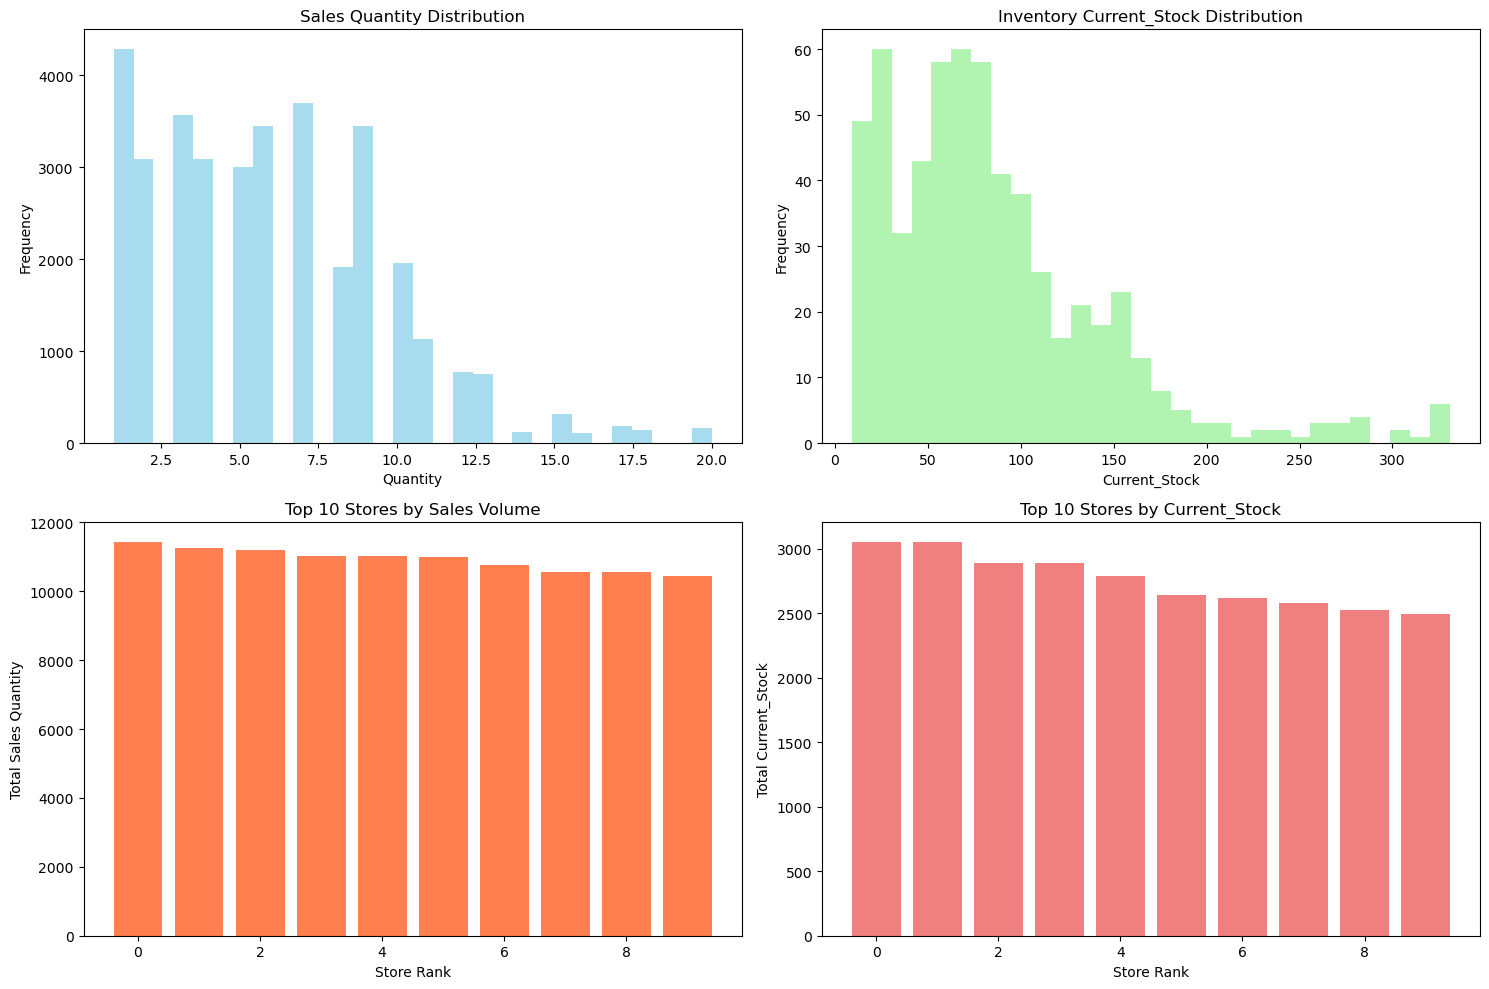

In [37]:
# Basic statistics
print("Checking data structure...")
print(f"Sales DataFrame columns: {sales_df.columns.tolist()}")
print(f"Inventory DataFrame columns: {inventory_df.columns.tolist()}")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sales quantity distribution
if 'quantity' in sales_df.columns:
    axes[0,0].hist(sales_df['quantity'], bins=30, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Sales Quantity Distribution')
    axes[0,0].set_xlabel('Quantity')
    axes[0,0].set_ylabel('Frequency')
else:
    axes[0,0].text(0.5, 0.5, 'Sales quantity column not found', ha='center', va='center', transform=axes[0,0].transAxes)
    axes[0,0].set_title('Sales Quantity Distribution - No Data')

# Inventory quantity distribution - check for different possible column names
inventory_qty_col = None
for col in ['quantity', 'current_stock', 'stock_quantity', 'inventory_level']:
    if col in inventory_df.columns:
        inventory_qty_col = col
        break

if inventory_qty_col:
    axes[0,1].hist(inventory_df[inventory_qty_col], bins=30, alpha=0.7, color='lightgreen')
    axes[0,1].set_title(f'Inventory {inventory_qty_col.title()} Distribution')
    axes[0,1].set_xlabel(inventory_qty_col.title())
    axes[0,1].set_ylabel('Frequency')
else:
    axes[0,1].text(0.5, 0.5, 'Inventory quantity column not found', ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('Inventory Quantity Distribution - No Data')

# Sales by store
if 'quantity' in sales_df.columns and 'store_id' in sales_df.columns:
    sales_by_store = sales_df.groupby('store_id')['quantity'].sum().sort_values(ascending=False).head(10)
    axes[1,0].bar(range(len(sales_by_store)), sales_by_store.values, color='coral')
    axes[1,0].set_title('Top 10 Stores by Sales Volume')
    axes[1,0].set_xlabel('Store Rank')
    axes[1,0].set_ylabel('Total Sales Quantity')
else:
    axes[1,0].text(0.5, 0.5, 'Sales data incomplete', ha='center', va='center', transform=axes[1,0].transAxes)
    axes[1,0].set_title('Sales by Store - No Data')

# Inventory by store
if inventory_qty_col and 'store_id' in inventory_df.columns:
    inventory_by_store = inventory_df.groupby('store_id')[inventory_qty_col].sum().sort_values(ascending=False).head(10)
    axes[1,1].bar(range(len(inventory_by_store)), inventory_by_store.values, color='lightcoral')
    axes[1,1].set_title(f'Top 10 Stores by {inventory_qty_col.title()}')
    axes[1,1].set_xlabel('Store Rank')
    axes[1,1].set_ylabel(f'Total {inventory_qty_col.title()}')
else:
    axes[1,1].text(0.5, 0.5, 'Inventory data incomplete', ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Inventory by Store - No Data')

plt.tight_layout()
plt.show()

## 6. Initialize Inventory Analyzer

In [38]:
# Initialize the inventory analyzer
print("Initializing Inventory Analyzer...")

# Initialize with DataFrames directly using the correct constructor parameters
analyzer = InventoryAnalyzer(
    sales_df=sales_df,
    inventory_df=inventory_df,
    stores=stores_df,
    products=products_df
)

Initializing Inventory Analyzer...


## 7. Perform Inventory Analysis

In [39]:
# Analyze sales data
print("Analyzing sales data...")
analysis_df = analyzer.analyze_sales_data()

print(f"Analysis complete: {len(analysis_df)} product-store combinations analyzed")
print(f"\nAnalysis DataFrame shape: {analysis_df.shape}")
print(f"Columns: {list(analysis_df.columns)}")

# Display sample analysis results
print("\nSample Analysis Results:")
display(analysis_df.head())

Analyzing sales data...
Analyzing sales data...
Sales data analysis complete.
Analysis complete: 600 product-store combinations analyzed

Analysis DataFrame shape: (600, 18)
Columns: ['store_id', 'product_id', 'current_stock', 'last_updated', 'quantity_sum', 'quantity_mean', 'quantity_std', 'quantity_count', 'revenue_sum', 'revenue_mean', 'quantity_cv', 'last_sale_date', 'days_since_last_sale', 'avg_daily_sales', 'days_of_inventory', 'city', 'category', 'sales_velocity']

Sample Analysis Results:


,store_id,product_id,current_stock,last_updated,quantity_sum,quantity_mean,quantity_std,quantity_count,revenue_sum,revenue_mean,quantity_cv,last_sale_date,days_since_last_sale,avg_daily_sales,days_of_inventory,city,category,sales_velocity
0,8,18,172,2026-01-21,391,7.377358,4.562499,53,101660000.0,1.918113e+06,0.618446,2026-01-18,3,7.377358,23.314578,Da Nang,Home Goods,Fast
1,3,18,133,2026-01-21,285,4.596774,2.724868,62,74100000.0,1.195161e+06,0.592778,2026-01-20,1,4.596774,28.933333,Hanoi,Home Goods,Slow
2,20,18,129,2026-01-21,338,5.281250,3.010399,64,87880000.0,1.373125e+06,0.570016,2026-01-18,3,5.281250,24.426036,Ho Chi Minh City,Home Goods,Slow
3,18,18,148,2026-01-21,296,5.584906,2.983506,53,76960000.0,1.452075e+06,0.534209,2026-01-21,0,5.584906,26.500000,Ho Chi Minh City,Home Goods,Fast
4,19,18,25,2026-01-21,370,5.285714,2.974007,70,96200000.0,1.374286e+06,0.562650,2026-01-21,0,5.285714,4.729730,Ho Chi Minh City,Home Goods,Slow


In [40]:
# Identify inventory imbalances
print("Identifying inventory imbalances...")

excess_df, needed_df = analyzer.identify_inventory_imbalances()

print(f"\nInventory Status Summary:")
print(f"   Excess inventory items: {len(excess_df)} (total units: {excess_df['excess_units'].sum():,})")
print(f"   Needed inventory items: {len(needed_df)} (total units: {needed_df['needed_units'].sum():,})")
print(f"   Balanced inventory items: {len(analysis_df) - len(excess_df) - len(needed_df)}")

total_excess = excess_df['excess_units'].sum()
total_needed = needed_df['needed_units'].sum()
excess_to_needed_ratio = total_excess / total_needed if total_needed > 0 else 0

print(f"\nTransfer Potential:")
print(f"   Total excess units: {total_excess:,}")
print(f"   Total needed units: {total_needed:,}")
print(f"   Excess to needed ratio: {excess_to_needed_ratio:.2f}")

Identifying inventory imbalances...
Identifying inventory imbalances...
Inventory Status Summary:
- Excess inventory items: 133 (total units: 6974)
- Needed inventory items: 134 (total units: 2667)
- Balanced inventory items: 333

Inventory Status Summary:
   Excess inventory items: 133 (total units: 6,974)
   Needed inventory items: 134 (total units: 2,667)
   Balanced inventory items: 333

Transfer Potential:
   Total excess units: 6,974
   Total needed units: 2,667
   Excess to needed ratio: 2.61


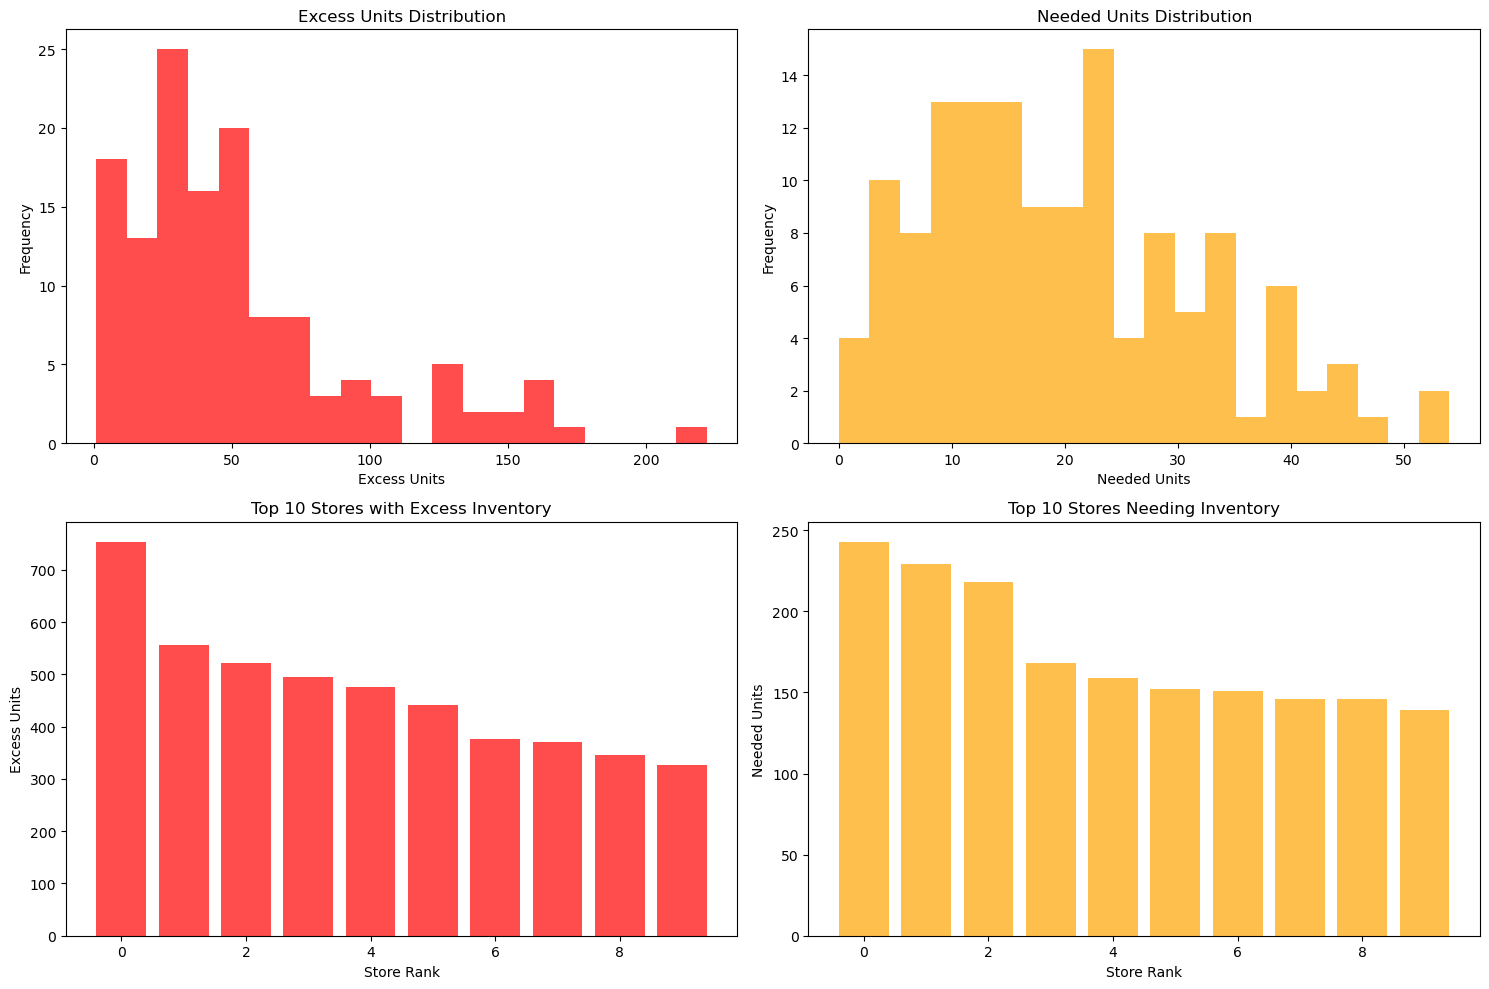

Inventory imbalance visualizations created


In [41]:
# Visualize inventory imbalances
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Excess quantity distribution
if len(excess_df) > 0:
    axes[0,0].hist(excess_df['excess_units'], bins=20, alpha=0.7, color='red')
    axes[0,0].set_title('Excess Units Distribution')
    axes[0,0].set_xlabel('Excess Units')
    axes[0,0].set_ylabel('Frequency')

# Needed quantity distribution
if len(needed_df) > 0:
    axes[0,1].hist(needed_df['needed_units'], bins=20, alpha=0.7, color='orange')
    axes[0,1].set_title('Needed Units Distribution')
    axes[0,1].set_xlabel('Needed Units')
    axes[0,1].set_ylabel('Frequency')

# Top stores with excess inventory
if len(excess_df) > 0:
    excess_by_store = excess_df.groupby('store_id')['excess_units'].sum().sort_values(ascending=False).head(10)
    axes[1,0].bar(range(len(excess_by_store)), excess_by_store.values, color='red', alpha=0.7)
    axes[1,0].set_title('Top 10 Stores with Excess Inventory')
    axes[1,0].set_xlabel('Store Rank')
    axes[1,0].set_ylabel('Excess Units')

# Top stores needing inventory
if len(needed_df) > 0:
    needed_by_store = needed_df.groupby('store_id')['needed_units'].sum().sort_values(ascending=False).head(10)
    axes[1,1].bar(range(len(needed_by_store)), needed_by_store.values, color='orange', alpha=0.7)
    axes[1,1].set_title('Top 10 Stores Needing Inventory')
    axes[1,1].set_xlabel('Store Rank')
    axes[1,1].set_ylabel('Needed Units')

plt.tight_layout()
plt.show()

print("Inventory imbalance visualizations created")

In [42]:
# Deep dive into transport cost matrix structure
print("TRANSPORT COST MATRIX DEEP ANALYSIS")
print("=" * 50)

# Basic matrix info
print(f"Matrix dimensions: {transport_cost_matrix.shape}")
print(f"Data type: {transport_cost_matrix.dtypes.iloc[0] if len(transport_cost_matrix.dtypes) > 0 else 'Unknown'}")

# Show a sample of the matrix
print(f"\nMatrix sample (top-left 5x5):")
display(transport_cost_matrix.iloc[:5, :5])

# Check diagonal values (same store to same store)
print(f"\nDiagonal Analysis (same store transfers):")
diagonal_values = []
for store_id in transport_cost_matrix.index[:10]:  # Check first 10
    if store_id in transport_cost_matrix.columns:
        diag_value = transport_cost_matrix.loc[store_id, store_id]
        diagonal_values.append((store_id, diag_value))

print(f"Sample diagonal values: {diagonal_values}")

# Count NaN entries in transport cost matrix
nan_cost_count = transport_cost_matrix.isna().sum().sum()
print(f"\nNaN transport cost entries: {nan_cost_count}")

# Check for systematic patterns in NaN values
if nan_cost_count > 0:
    print(f"\nNaN Pattern Analysis:")

    # Check if all NaN values are on diagonal
    nan_mask = transport_cost_matrix.isna()
    total_diagonal = len(transport_cost_matrix.index)
    diagonal_nans = sum(nan_mask.loc[i, i] for i in transport_cost_matrix.index if i in transport_cost_matrix.columns)

    print(f"   Total diagonal positions: {total_diagonal}")
    print(f"   Diagonal NaN entries: {diagonal_nans}")
    print(f"   All NaN are diagonal: {diagonal_nans == nan_cost_count}")

    if diagonal_nans == nan_cost_count:
        print(f"   EXPLANATION: All NaN entries are on the diagonal (same store to same store)")
        print(f"   This is likely intentional - stores don't transfer to themselves")
        print(f"   This should NOT cause optimization problems")
    else:
        print(f"   WARNING: Some NaN entries are off-diagonal - this WILL cause problems")

        # Find off-diagonal NaN entries
        off_diagonal_nans = []
        for i in transport_cost_matrix.index:
            for j in transport_cost_matrix.columns:
                if i != j and nan_mask.loc[i, j]:
                    off_diagonal_nans.append((i, j))

        print(f"   Off-diagonal NaN locations: {off_diagonal_nans[:5]}")

# Statistics of non-NaN values
valid_costs = transport_cost_matrix[~transport_cost_matrix.isna()]
if len(valid_costs.values.flatten()) > 0:
    valid_costs_flat = valid_costs.values.flatten()
    valid_costs_flat = valid_costs_flat[~pd.isna(valid_costs_flat)]

    print(f"\nValid Cost Statistics:")
    print(f"   Valid entries: {len(valid_costs_flat)}")
    print(f"   Min cost: {valid_costs_flat.min():,.0f} VND")
    print(f"   Max cost: {valid_costs_flat.max():,.0f} VND")
    print(f"   Mean cost: {valid_costs_flat.mean():,.0f} VND")
    print(f"   Median cost: {np.median(valid_costs_flat):,.0f} VND")

print("=" * 50)

TRANSPORT COST MATRIX DEEP ANALYSIS
Matrix dimensions: (20, 20)
Data type: float64

Matrix sample (top-left 5x5):


,1,2,3,4,5
1,NaN,47913.676851,34188.649520,34115.046064,44444.603965
2,47913.676851,NaN,30526.745670,14876.176811,17779.549131
3,34188.649520,30526.745670,NaN,18533.012013,40962.506220
4,34115.046064,14876.176811,18533.012013,NaN,22453.648606
5,44444.603965,17779.549131,40962.506220,22453.648606,NaN



Diagonal Analysis (same store transfers):
Sample diagonal values: [(1, nan), (2, nan), (3, nan), (4, nan), (5, nan), (6, nan), (7, nan), (8, nan), (9, nan), (10, nan)]

NaN transport cost entries: 20

NaN Pattern Analysis:
   Total diagonal positions: 20
   Diagonal NaN entries: 20
   All NaN are diagonal: True
   EXPLANATION: All NaN entries are on the diagonal (same store to same store)
   This is likely intentional - stores don't transfer to themselves
   This should NOT cause optimization problems

Valid Cost Statistics:
   Valid entries: 380
   Min cost: 2,417 VND
   Max cost: 1,388,715 VND
   Mean cost: 699,648 VND
   Median cost: 729,186 VND


## 8. Rule-Based Optimization Algorithm

In [43]:
# Initialize Rule-Based Optimizer
print("Initializing Rule-Based Optimizer...")

rule_optimizer = RuleBasedOptimizer(
    distance_matrix=distance_matrix,
    transport_cost_matrix=transport_cost_matrix
)

print("Rule-based optimizer initialized")

# Validate optimizer setup
print(f"Optimizer Validation:")
print(f"   Transport cost matrix shape: {transport_cost_matrix.shape}")
print(f"   Transport cost matrix type: {type(transport_cost_matrix)}")
print(f"   Matrix index type: {transport_cost_matrix.index.dtype}")
print(f"   Matrix columns type: {transport_cost_matrix.columns.dtype}")

# Test a sample cost lookup
if len(excess_df) > 0 and len(needed_df) > 0:
    sample_excess_store = excess_df.iloc[0]['store_id']
    sample_needed_store = needed_df.iloc[0]['store_id']
    print(f"   Sample stores - Excess: {sample_excess_store} ({type(sample_excess_store)})")
    print(f"   Sample stores - Needed: {sample_needed_store} ({type(sample_needed_store)})")

    try:
        if (sample_excess_store in transport_cost_matrix.index and
            sample_needed_store in transport_cost_matrix.columns):
            sample_cost = transport_cost_matrix.loc[sample_excess_store, sample_needed_store]
            print(f"   Sample cost lookup successful: {sample_cost:,.0f} VND")
        else:
            print(f"   Sample stores not found in matrix")
            print(f"   Excess store in index: {sample_excess_store in transport_cost_matrix.index}")
            print(f"   Needed store in columns: {sample_needed_store in transport_cost_matrix.columns}")
    except Exception as e:
        print(f"   Error in cost lookup: {e}")

print(f"\nReady to optimize transfers for:")
print(f"   - {len(excess_df)} excess items")
print(f"   - {len(needed_df)} needed items")

Initializing Rule-Based Optimizer...
Rule-based optimizer initialized
Optimizer Validation:
   Transport cost matrix shape: (20, 20)
   Transport cost matrix type: <class 'pandas.core.frame.DataFrame'>
   Matrix index type: int64
   Matrix columns type: int64
   Sample stores - Excess: 8 (<class 'numpy.int64'>)
   Sample stores - Needed: 19 (<class 'numpy.int64'>)
   Sample cost lookup successful: 720,674 VND

Ready to optimize transfers for:
   - 133 excess items
   - 134 needed items


### Rule-Based Algorithm Logic (Simple Explanation)

The rule-based algorithm follows this simple logic:

1. **Sort needed items** by urgency (highest need first)
2. **For each needed item:**
   - Find all stores with excess of the same product
   - Sort excess stores by transport cost (cheapest first)
   - Transfer from closest/cheapest excess store until need is satisfied
3. **Continue** until all needs are satisfied or no more excess available

In [44]:
# Run Rule-Based Optimization
print("Running Rule-Based Optimization...")
start_time = datetime.now()

rule_transfer_plan = rule_optimizer.optimize(excess_df, needed_df)

end_time = datetime.now()
rule_duration = (end_time - start_time).total_seconds()

print(f"\nRule-based optimization completed in {rule_duration:.2f} seconds")

# Display results summary
if rule_transfer_plan is not None and len(rule_transfer_plan) > 0:
    total_transfers = len(rule_transfer_plan)
    total_units = rule_transfer_plan['units'].sum()
    total_cost = rule_transfer_plan['transport_cost'].sum()
    avg_cost_per_unit = total_cost / total_units if total_units > 0 else 0

    print(f"\nRule-Based Results Summary:")
    print(f"   Total transfers: {total_transfers}")
    print(f"   Total units transferred: {total_units:,}")
    print(f"   Total transport cost: {total_cost:,.0f} VND")
    print(f"   Average cost per unit: {avg_cost_per_unit:,.0f} VND")
else:
    print("No transfers generated by rule-based algorithm")
    rule_transfer_plan = pd.DataFrame()  # Create empty DataFrame for consistency

2026-01-21 22:36:48 - optimization_rule_based_optimization - INFO - ============================================================
2026-01-21 22:36:48 - optimization_rule_based_optimization - INFO - ============================================================
2026-01-21 22:36:48 - optimization_rule_based_optimization - INFO - Starting Rule Based Optimization Execution
2026-01-21 22:36:48 - optimization_rule_based_optimization - INFO - ============================================================
2026-01-21 22:36:48 - optimization_rule_based_optimization - INFO - Execution Parameters:
2026-01-21 22:36:48 - optimization_rule_based_optimization - INFO -   - excess_items: 133
2026-01-21 22:36:48 - optimization_rule_based_optimization - INFO -   - needed_items: 134
2026-01-21 22:36:48 - optimization_rule_based_optimization - INFO -   - algorithm: Rule-Based Optimization
2026-01-21 22:36:48 - optimization_rule_based_optimization - INFO - Log file: logs/2026-01-21/rule_based_optimization.log
202

Running Rule-Based Optimization...
Generating rule-based transfer plan...


Processing needed inventory: 100%|██████████| 134/134 [00:00<00:00, 993.77item/s, product=11, store=7]
2026-01-21 22:36:48 - optimization_rule_based_optimization - INFO - Rule-Based Transfer Plan Summary:
2026-01-21 22:36:48 - optimization_rule_based_optimization - INFO - Total transfers: 168
2026-01-21 22:36:48 - optimization_rule_based_optimization - INFO - Total units to transfer: 2649
2026-01-21 22:36:48 - optimization_rule_based_optimization - INFO - Total transport cost: 936,276,271 VND
2026-01-21 22:36:48 - optimization_rule_based_optimization - INFO - Average cost per unit: 353,445 VND
2026-01-21 22:36:48 - optimization_rule_based_optimization - INFO - ------------------------------------------------------------
2026-01-21 22:36:48 - optimization_rule_based_optimization - INFO - Rule Based Optimization Execution Completed
2026-01-21 22:36:48 - optimization_rule_based_optimization - INFO - Total Execution Time: 0.18 seconds
2026-01-21 22:36:48 - optimization_rule_based_optimizat

Rule-Based Transfer Plan Summary:
- Total transfers: 168
- Total units to transfer: 2649
- Total transport cost: 936,276,271 VND
- Average cost per unit: 353,445 VND

Rule-based optimization completed in 0.18 seconds

Rule-Based Results Summary:
   Total transfers: 168
   Total units transferred: 2,649
   Total transport cost: 936,276,271 VND
   Average cost per unit: 353,445 VND


In [45]:
# Analyze rule-based transfer plan
if len(rule_transfer_plan) > 0:
    print("Rule-Based Transfer Plan Analysis:")

    # Display sample transfers
    print("\nSample Transfers (first 10):")
    display(rule_transfer_plan.head(10))

    # Validate transport costs
    print("\nTransport Cost Analysis:")
    zero_cost_transfers = rule_transfer_plan[rule_transfer_plan['transport_cost'] == 0]
    print(f"   Transfers with zero cost: {len(zero_cost_transfers)} of {len(rule_transfer_plan)}")

    if len(zero_cost_transfers) > 0:
        print(f"  WARNING: Zero-cost transfers detected!")
        print("   Sample zero-cost transfers:")
        display(zero_cost_transfers.head(3))
    else:
        print(f"   All transfers have valid transport costs")
        print(f"   Cost range: {rule_transfer_plan['transport_cost'].min():,.0f} - {rule_transfer_plan['transport_cost'].max():,.0f} VND")

    # Transfer statistics
    transfer_stats = {
        'Total Transfers': len(rule_transfer_plan),
        'Unique Products': rule_transfer_plan['product_id'].nunique(),
        'Source Stores': rule_transfer_plan['from_store_id'].nunique(),
        'Destination Stores': rule_transfer_plan['to_store_id'].nunique(),
        'Min Transfer Quantity': rule_transfer_plan['units'].min(),
        'Max Transfer Quantity': rule_transfer_plan['units'].max(),
        'Avg Transfer Quantity': rule_transfer_plan['units'].mean(),
        'Min Transport Cost': rule_transfer_plan['transport_cost'].min(),
        'Max Transport Cost': rule_transfer_plan['transport_cost'].max(),
        'Avg Transport Cost': rule_transfer_plan['transport_cost'].mean()
    }

    print("\nTransfer Statistics:")
    for key, value in transfer_stats.items():
        if isinstance(value, float):
            print(f"   {key}: {value:,.2f}")
        else:
            print(f"   {key}: {value:,}")

    # Cost efficiency analysis
    if rule_transfer_plan['transport_cost'].sum() > 0:
        avg_cost_per_unit = rule_transfer_plan['transport_cost'].sum() / rule_transfer_plan['units'].sum()
        print(f"\nCost Efficiency:")
        print(f"   Average cost per unit transferred: {avg_cost_per_unit:,.0f} VND")

        # Cost distribution analysis
        cost_quartiles = rule_transfer_plan['transport_cost'].describe()
        print(f"   Cost distribution (VND):")
        print(f"     - Q1 (25%): {cost_quartiles['25%']:,.0f}")
        print(f"     - Median: {cost_quartiles['50%']:,.0f}")
        print(f"     - Q3 (75%): {cost_quartiles['75%']:,.0f}")
else:
    print("No rule-based transfer plan generated - check data compatibility and validation messages above.")

Rule-Based Transfer Plan Analysis:

Sample Transfers (first 10):


,from_store_id,to_store_id,product_id,units,distance_km,transport_cost
0,5,7,3,54,20.526358,2.660216e+06
1,5,2,4,39,7.408145,6.934024e+05
2,9,2,4,14,617.865143,1.038013e+07
3,6,4,1,46,7.824045,8.637746e+05
4,3,6,5,45,11.382327,1.229291e+06
5,2,4,2,44,6.198407,6.545518e+05
6,3,2,6,44,12.719477,1.343177e+06
7,19,14,23,13,6.786762,2.117470e+05
8,10,14,23,29,609.114392,2.119718e+07
9,3,6,6,42,11.382327,1.147339e+06



Transport Cost Analysis:
   Transfers with zero cost: 0 of 168
   All transfers have valid transport costs
   Cost range: 19,385 - 39,480,566 VND

Transfer Statistics:
   Total Transfers: 168
   Unique Products: 30
   Source Stores: 20
   Destination Stores: 20
   Min Transfer Quantity: 1
   Max Transfer Quantity: 54
   Avg Transfer Quantity: 15.77
   Min Transport Cost: 19,384.95
   Max Transport Cost: 39,480,565.66
   Avg Transport Cost: 5,573,073.04

Cost Efficiency:
   Average cost per unit transferred: 353,445 VND
   Cost distribution (VND):
     - Q1 (25%): 246,219
     - Median: 884,984
     - Q3 (75%): 7,972,806


## 9. Genetic Algorithm Optimization

In [46]:
# Initialize Genetic Algorithm Optimizer
print("Initializing Genetic Algorithm Optimizer...")

ga_optimizer = GeneticAlgorithmOptimizer(
    distance_matrix=distance_matrix,
    transport_cost_matrix=transport_cost_matrix
)

print("Genetic algorithm optimizer initialized")
print(f"GA Configuration:")
print(f"   Population size: {GA_POPULATION_SIZE}")
print(f"   Generations: {GA_GENERATIONS}")
print(f"   Crossover probability: {GA_CROSSOVER_PROB}")
print(f"   Mutation probability: {GA_MUTATION_PROB}")

Initializing Genetic Algorithm Optimizer...
Genetic algorithm optimizer initialized
GA Configuration:
   Population size: 50
   Generations: 50
   Crossover probability: 0.6
   Mutation probability: 0.3


### Genetic Algorithm Logic (Simple Explanation)

The genetic algorithm follows these steps:

1. **Create initial population** - Generate random transfer solutions
2. **Evaluate fitness** - Calculate transport cost for each solution (lower is better)
3. **Selection** - Choose best solutions as parents
4. **Crossover** - Combine parent solutions to create offspring
5. **Mutation** - Randomly modify some solutions for diversity
6. **Replace population** - Keep best solutions for next generation
7. **Repeat** for specified number of generations
8. **Return best solution** found

In [47]:
# Run Genetic Algorithm Optimization
print("Running Genetic Algorithm Optimization...")
start_time = datetime.now()

ga_transfer_plan = ga_optimizer.optimize(
    excess_inventory=excess_df,
    needed_inventory=needed_df,
    population_size=GA_POPULATION_SIZE,
    num_generations=GA_GENERATIONS,
    crossover_prob=GA_CROSSOVER_PROB,
    mutation_prob=GA_MUTATION_PROB,
    tournament_size=3,
    verbose=True
)

end_time = datetime.now()
ga_duration = (end_time - start_time).total_seconds()

print(f"\nGenetic algorithm optimization completed in {ga_duration:.2f} seconds")

# Display results summary
if ga_transfer_plan is not None and len(ga_transfer_plan) > 0:
    total_transfers = len(ga_transfer_plan)
    total_units = ga_transfer_plan['units'].sum()
    total_cost = ga_transfer_plan['transport_cost'].sum()
    avg_cost_per_unit = total_cost / total_units if total_units > 0 else 0

    print(f"\nGenetic Algorithm Results Summary:")
    print(f"   Total transfers: {total_transfers}")
    print(f"   Total units transferred: {total_units:,}")
    print(f"   Total transport cost: {total_cost:,.0f} VND")
    print(f"   Average cost per unit: {avg_cost_per_unit:,.0f} VND")
else:
    print("No transfers generated by genetic algorithm")
    ga_transfer_plan = pd.DataFrame()  # Create empty DataFrame for consistency

2026-01-21 22:36:48 - optimization_genetic_algorithm_optimization - INFO - ============================================================
2026-01-21 22:36:48 - optimization_genetic_algorithm_optimization - INFO - ============================================================
2026-01-21 22:36:48 - optimization_genetic_algorithm_optimization - INFO - Starting Genetic Algorithm Optimization Execution
2026-01-21 22:36:48 - optimization_genetic_algorithm_optimization - INFO - ============================================================
2026-01-21 22:36:48 - optimization_genetic_algorithm_optimization - INFO - Execution Parameters:
2026-01-21 22:36:48 - optimization_genetic_algorithm_optimization - INFO -   - excess_items: 133
2026-01-21 22:36:48 - optimization_genetic_algorithm_optimization - INFO -   - needed_items: 134
2026-01-21 22:36:48 - optimization_genetic_algorithm_optimization - INFO -   - population_size: 50
2026-01-21 22:36:48 - optimization_genetic_algorithm_optimization - INFO -   

Running Genetic Algorithm Optimization...
Starting Genetic Algorithm Optimization...
Population: 50, Generations: 50
Starting Genetic Algorithm Optimization...
Population: 50, Generations: 50
Found 30 products for optimization

Step 1: Creating initial population...


2026-01-21 22:36:48 - optimization_genetic_algorithm_optimization - INFO - Step 3: Evolution over 50 generations...


Step 2: Evaluating initial fitness...
Generation 0: Best=1,743,190,136, Avg=1,916,546,927

Step 3: Evolution over 50 generations...


GA Evolution: 100%|██████████| 50/50 [05:41<00:00,  6.82s/gen, Best=739,162,458, Avg=753,375,263, Transfers=284]
2026-01-21 22:42:29 - optimization_genetic_algorithm_optimization - INFO - Step 4: Extracting best solution...
2026-01-21 22:42:30 - optimization_genetic_algorithm_optimization - INFO - Genetic Algorithm Results:
2026-01-21 22:42:30 - optimization_genetic_algorithm_optimization - INFO - Best fitness (total cost): 739,162,458
2026-01-21 22:42:30 - optimization_genetic_algorithm_optimization - INFO - Total transfers: 284
2026-01-21 22:42:30 - optimization_genetic_algorithm_optimization - INFO - Total units to transfer: 1483
2026-01-21 22:42:30 - optimization_genetic_algorithm_optimization - INFO - Total transport cost: 739,162,458
2026-01-21 22:42:30 - optimization_genetic_algorithm_optimization - INFO - Average cost per unit: 498,424
2026-01-21 22:42:30 - optimization_genetic_algorithm_optimization - INFO - ------------------------------------------------------------
2026-01-


Step 4: Extracting best solution...

Genetic Algorithm Results:
   • Best fitness (total cost): 739,162,458
   • Total transfers: 284
   • Total units to transfer: 1483
   • Total transport cost: 739,162,458
   • Average cost per unit: 498,424

Genetic algorithm optimization completed in 341.80 seconds

Genetic Algorithm Results Summary:
   Total transfers: 284
   Total units transferred: 1,483
   Total transport cost: 739,162,458 VND
   Average cost per unit: 498,424 VND


In [48]:
# Analyze genetic algorithm transfer plan
if len(ga_transfer_plan) > 0:
    print("Genetic Algorithm Transfer Plan Analysis:")

    # Display sample transfers
    print("\nSample Transfers (first 10):")
    display(ga_transfer_plan.head(10))

    # Transfer statistics
    transfer_stats = {
        'Total Transfers': len(ga_transfer_plan),
        'Unique Products': ga_transfer_plan['product_id'].nunique(),
        'Source Stores': ga_transfer_plan['from_store_id'].nunique(),
        'Destination Stores': ga_transfer_plan['to_store_id'].nunique(),
        'Min Transfer Quantity': ga_transfer_plan['units'].min(),
        'Max Transfer Quantity': ga_transfer_plan['units'].max(),
        'Avg Transfer Quantity': ga_transfer_plan['units'].mean(),
        'Min Transport Cost': ga_transfer_plan['transport_cost'].min(),
        'Max Transport Cost': ga_transfer_plan['transport_cost'].max(),
        'Avg Transport Cost': ga_transfer_plan['transport_cost'].mean()
    }

    print("\nTransfer Statistics:")
    for key, value in transfer_stats.items():
        if isinstance(value, float):
            print(f"   {key}: {value:,.2f}")
        else:
            print(f"   {key}: {value:,}")

Genetic Algorithm Transfer Plan Analysis:

Sample Transfers (first 10):


,from_store_id,to_store_id,product_id,units,distance_km,transport_cost
0,10,8,1,4,3.335505,3.202085e+04
1,1,8,1,3,601.325318,2.164771e+06
2,6,8,1,1,608.538607,7.302463e+05
3,12,8,1,1,5.479839,1.315161e+04
4,10,2,1,3,618.062436,2.225025e+06
5,1,2,1,1,19.964032,4.791368e+04
6,6,2,1,1,12.929194,3.103006e+04
7,12,2,1,1,615.808421,7.389701e+05
8,10,4,1,28,612.102839,2.056666e+07
9,1,4,1,16,14.214603,5.458407e+05



Transfer Statistics:
   Total Transfers: 284
   Unique Products: 26
   Source Stores: 20
   Destination Stores: 20
   Min Transfer Quantity: 1
   Max Transfer Quantity: 44
   Avg Transfer Quantity: 5.22
   Min Transport Cost: 5,519.75
   Max Transport Cost: 28,819,313.13
   Avg Transport Cost: 2,602,684.71


## 10. Algorithm Comparison and Analysis

In [49]:
# Create comprehensive comparison
print("Comparing Optimization Algorithms...")

# Prepare results dictionary
results_dict = {}

if rule_transfer_plan is not None and len(rule_transfer_plan) > 0:
    results_dict["Rule-Based"] = rule_transfer_plan

if ga_transfer_plan is not None and len(ga_transfer_plan) > 0:
    results_dict["Genetic Algorithm"] = ga_transfer_plan

# Performance comparison table
comparison_data = []

if "Rule-Based" in results_dict:
    plan = results_dict["Rule-Based"]
    comparison_data.append({
        'Algorithm': 'Rule-Based',
        'Execution Time (s)': f"{rule_duration:.2f}",
        'Total Transfers': len(plan),
        'Total Units': plan['units'].sum(),
        'Total Cost (VND)': f"{plan['transport_cost'].sum():,.0f}",
        'Avg Cost per Unit': f"{plan['transport_cost'].sum() / plan['units'].sum():,.0f}",
        'Products Involved': plan['product_id'].nunique(),
        'Stores Involved': len(set(plan['from_store_id'].unique()) | set(plan['to_store_id'].unique()))
    })

if "Genetic Algorithm" in results_dict:
    plan = results_dict["Genetic Algorithm"]
    comparison_data.append({
        'Algorithm': 'Genetic Algorithm',
        'Execution Time (s)': f"{ga_duration:.2f}",
        'Total Transfers': len(plan),
        'Total Units': plan['units'].sum(),
        'Total Cost (VND)': f"{plan['transport_cost'].sum():,.0f}",
        'Avg Cost per Unit': f"{plan['transport_cost'].sum() / plan['units'].sum():,.0f}",
        'Products Involved': plan['product_id'].nunique(),
        'Stores Involved': len(set(plan['from_store_id'].unique()) | set(plan['to_store_id'].unique()))
    })

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    print("\nAlgorithm Performance Comparison:")
    display(comparison_df)
else:
    print("No successful optimization results to compare")

Comparing Optimization Algorithms...

Algorithm Performance Comparison:


,Algorithm,Execution Time (s),Total Transfers,Total Units,Total Cost (VND),Avg Cost per Unit,Products Involved,Stores Involved
0,Rule-Based,0.18,168,2649,"936,276,271","353,445",30,20
1,Genetic Algorithm,341.80,284,1483,"739,162,458","498,424",26,20


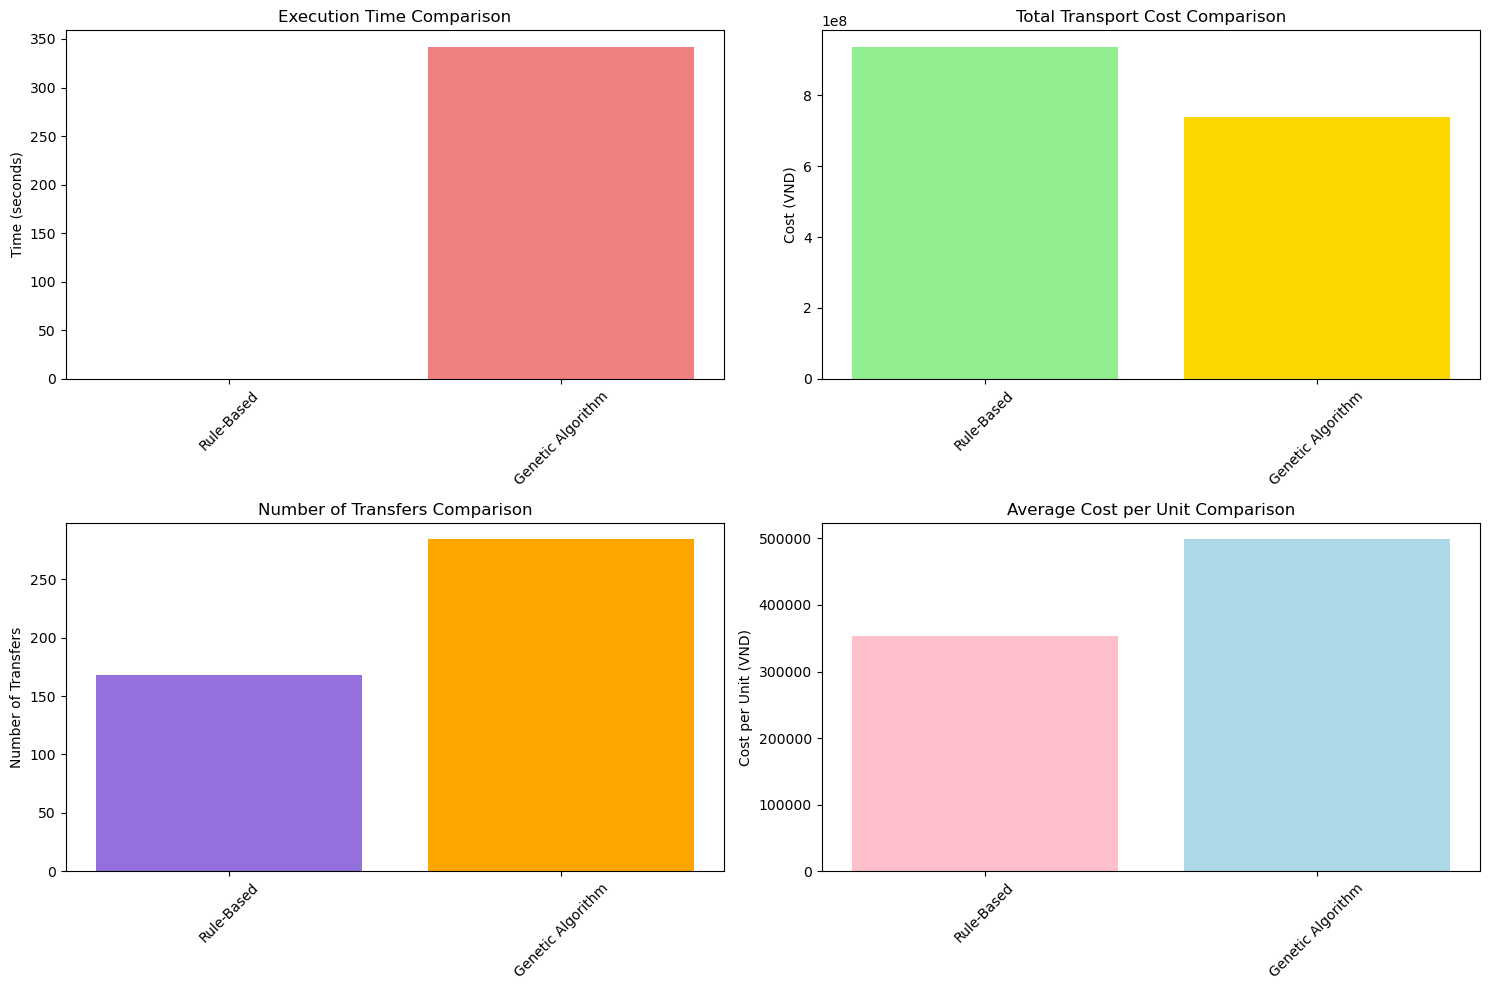

Algorithm comparison visualizations created


In [50]:
# Visualize algorithm comparison
if len(comparison_data) >= 2:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Extract numeric values for plotting
    algorithms = [row['Algorithm'] for row in comparison_data]
    execution_times = [float(row['Execution Time (s)']) for row in comparison_data]
    total_costs = [float(row['Total Cost (VND)'].replace(',', '')) for row in comparison_data]
    total_transfers = [row['Total Transfers'] for row in comparison_data]
    avg_costs = [float(row['Avg Cost per Unit'].replace(',', '')) for row in comparison_data]

    # Execution time comparison
    axes[0,0].bar(algorithms, execution_times, color=['skyblue', 'lightcoral'])
    axes[0,0].set_title('Execution Time Comparison')
    axes[0,0].set_ylabel('Time (seconds)')
    axes[0,0].tick_params(axis='x', rotation=45)

    # Total cost comparison
    axes[0,1].bar(algorithms, total_costs, color=['lightgreen', 'gold'])
    axes[0,1].set_title('Total Transport Cost Comparison')
    axes[0,1].set_ylabel('Cost (VND)')
    axes[0,1].tick_params(axis='x', rotation=45)

    # Number of transfers comparison
    axes[1,0].bar(algorithms, total_transfers, color=['mediumpurple', 'orange'])
    axes[1,0].set_title('Number of Transfers Comparison')
    axes[1,0].set_ylabel('Number of Transfers')
    axes[1,0].tick_params(axis='x', rotation=45)

    # Average cost per unit comparison
    axes[1,1].bar(algorithms, avg_costs, color=['pink', 'lightblue'])
    axes[1,1].set_title('Average Cost per Unit Comparison')
    axes[1,1].set_ylabel('Cost per Unit (VND)')
    axes[1,1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    print("Algorithm comparison visualizations created")
else:
    print("Need at least 2 algorithms to create comparison charts")

## 11. Best Algorithm Selection and Final Results

In [51]:
# Determine the best algorithm
if results_dict:
    print("Selecting Best Algorithm...")

    best_algorithm = None
    best_cost = float('inf')
    best_plan = None

    for algorithm, plan in results_dict.items():
        if len(plan) > 0:
            total_cost = plan['transport_cost'].sum()
            if total_cost < best_cost:
                best_cost = total_cost
                best_algorithm = algorithm
                best_plan = plan

    if best_algorithm:
        print(f"\nBest Algorithm: {best_algorithm}")
        print(f"Best Total Cost: {best_cost:,.0f} VND")
        print(f"Number of Transfers: {len(best_plan)}")
        print(f"Total Units Transferred: {best_plan['units'].sum():,}")

        # Display top 10 transfers from best plan
        print(f"\nTop 10 Transfers from Best Algorithm ({best_algorithm}):")
        display(best_plan.nlargest(10, 'units')[['product_id', 'from_store_id', 'to_store_id', 'units', 'transport_cost']])
    else:
        print("No valid optimization results found")
else:
    print("No optimization algorithms were successfully executed")

Selecting Best Algorithm...

Best Algorithm: Genetic Algorithm
Best Total Cost: 739,162,458 VND
Number of Transfers: 284
Total Units Transferred: 1,483

Top 10 Transfers from Best Algorithm (Genetic Algorithm):


,product_id,from_store_id,to_store_id,units,transport_cost
77,6,3,2,44,1.343177e+06
26,2,1,4,39,1.330487e+06
30,3,5,1,34,1.511117e+06
28,3,5,3,31,1.269838e+06
84,7,1,3,31,1.059848e+06
8,1,10,4,28,2.056666e+07
78,6,3,6,26,7.102572e+05
68,5,8,6,24,1.752591e+07
260,24,17,20,23,7.697093e+05
59,5,3,1,21,7.179616e+05


## 12. Impact Analysis and Benefits

In [52]:
# Analyze the impact of the best solution
if best_algorithm and best_plan is not None:
    print(f"Analyzing Impact of {best_algorithm} Solution...")

    # Calculate inventory impact
    post_transfer_impact, post_analysis = analyzer.evaluate_plan_impact(best_plan)

    print("\nTransfer Plan Impact Summary:")
    display(post_transfer_impact)

    # Key benefits summary
    print("\nKey Benefits Summary:")

    # Extract improvement metrics
    improvements = {}
    for col in post_transfer_impact.columns:
        if 'Improvement' in col or 'Reduction' in col or 'Increase' in col:
            for idx in post_transfer_impact.index:
                value = post_transfer_impact.loc[idx, col]
                if pd.notna(value) and value != 0:
                    improvements[f"{idx} - {col}"] = value

    for metric, value in improvements.items():
        if isinstance(value, (int, float)):
            if abs(value) >= 1000000:  # Large numbers (costs)
                print(f"   {metric}: {value:,.0f}")
            elif abs(value) >= 1:  # Regular numbers
                print(f"   {metric}: {value:,.2f}")
            else:  # Percentages
                print(f"   {metric}: {value:.2%}")
        else:
            print(f"   {metric}: {value}")

Analyzing Impact of Genetic Algorithm Solution...
Evaluating transfer plan impact...

Transfer Plan Impact Summary:
                               Before Transfer  After Transfer  \
Excess Items                      1.330000e+02    1.180000e+02   
Needed Items                      1.340000e+02    1.300000e+02   
Balanced Items                    3.330000e+02    3.520000e+02   
Avg Days of Inventory             1.484332e+01    1.478758e+01   
Inventory Imbalance (StdDev)      1.009225e+01    9.009452e+00   
Product Turnover                  2.459018e+01    2.468288e+01   
Total Inventory Value             9.900849e+09    9.900849e+09   
Excess Inventory Value            4.518960e+09    3.962785e+09   
Reduction in Excess Items                  NaN             NaN   
Reduction in Needed Items                  NaN             NaN   
Increase in Balanced Items                 NaN             NaN   
Product Turnover Improvement               NaN             NaN   
Inventory Balance Improvem

,Before Transfer,After Transfer,Improvement,Transfer Plan
Excess Items,1.330000e+02,1.180000e+02,NaN,NaN
Needed Items,1.340000e+02,1.300000e+02,NaN,NaN
Balanced Items,3.330000e+02,3.520000e+02,NaN,NaN
Avg Days of Inventory,1.484332e+01,1.478758e+01,NaN,NaN
Inventory Imbalance (StdDev),1.009225e+01,9.009452e+00,NaN,NaN
Product Turnover,2.459018e+01,2.468288e+01,NaN,NaN
Total Inventory Value,9.900849e+09,9.900849e+09,NaN,NaN
Excess Inventory Value,4.518960e+09,3.962785e+09,NaN,NaN
Reduction in Excess Items,NaN,NaN,15,NaN
Reduction in Needed Items,NaN,NaN,4,NaN



Key Benefits Summary:
   Reduction in Excess Items - Improvement: 15
   Reduction in Needed Items - Improvement: 4
   Increase in Balanced Items - Improvement: 19
   Product Turnover Improvement - Improvement: 0.38%
   Inventory Balance Improvement - Improvement: 10.73%
   Reduction in Excess Value - Improvement: 556,175,258


## 13. Final Summary and Recommendations

In [53]:
# Create final summary
print("FINAL OPTIMIZATION SUMMARY")
print("=" * 50)

print(f"\nINVENTORY SITUATION:")
print(f"   • Total stores analyzed: {stores_df['store_id'].nunique()}")
print(f"   • Total products analyzed: {products_df['product_id'].nunique()}")
print(f"   • Items with excess inventory: {len(excess_df)} ({total_excess:,} units)")
print(f"   • Items needing inventory: {len(needed_df)} ({total_needed:,} units)")

if results_dict:
    print(f"\nOPTIMIZATION RESULTS:")
    for algorithm, plan in results_dict.items():
        if len(plan) > 0:
            execution_time = rule_duration if algorithm == "Rule-Based" else ga_duration
            print(f"   • {algorithm}:")
            print(f"     - Execution time: {execution_time:.2f} seconds")
            print(f"     - Transfers generated: {len(plan)}")
            print(f"     - Total cost: {plan['transport_cost'].sum():,.0f} VND")
            print(f"     - Units transferred: {plan['units'].sum():,}")

if 'best_algorithm' in locals() and best_algorithm:
    print(f"\nRECOMMENDED SOLUTION:")
    print(f"   • Best algorithm: {best_algorithm}")
    print(f"   • Total optimization cost: {best_cost:,.0f} VND")
    print(f"   • Transfers to execute: {len(best_plan)}")
    print(f"   • Expected benefits: Improved inventory balance across stores")

print("\nAnalysis Complete!")
print("=" * 50)

FINAL OPTIMIZATION SUMMARY

INVENTORY SITUATION:
   • Total stores analyzed: 20
   • Total products analyzed: 30
   • Items with excess inventory: 133 (6,974 units)
   • Items needing inventory: 134 (2,667 units)

OPTIMIZATION RESULTS:
   • Rule-Based:
     - Execution time: 0.18 seconds
     - Transfers generated: 168
     - Total cost: 936,276,271 VND
     - Units transferred: 2,649
   • Genetic Algorithm:
     - Execution time: 341.80 seconds
     - Transfers generated: 284
     - Total cost: 739,162,458 VND
     - Units transferred: 1,483

RECOMMENDED SOLUTION:
   • Best algorithm: Genetic Algorithm
   • Total optimization cost: 739,162,458 VND
   • Transfers to execute: 284
   • Expected benefits: Improved inventory balance across stores

Analysis Complete!


## 14. Export Results (Optional)

In [54]:
# Save results to files (optional)
save_results = True  # Set to True if you want to save results

if save_results and best_plan is not None:
    print("Saving Results to Files...")

    # Create results directory if it doesn't exist
    results_dir.mkdir(exist_ok=True)

    # Save best transfer plan
    best_plan_path = results_dir / 'notebook_best_transfer_plan.csv'
    best_plan.to_csv(best_plan_path, index=False)
    print(f"   Best transfer plan saved: {best_plan_path}")

    # Save comparison summary
    if comparison_data:
        comparison_path = results_dir / 'notebook_algorithm_comparison.csv'
        pd.DataFrame(comparison_data).to_csv(comparison_path, index=False)
        print(f"   Algorithm comparison saved: {comparison_path}")

    # Save analysis summary
    analysis_summary = {
        'timestamp': datetime.now().isoformat(),
        'best_algorithm': best_algorithm,
        'total_cost': float(best_cost),
        'total_transfers': len(best_plan),
        'total_units': int(best_plan['units'].sum()),
        'excess_items': len(excess_df),
        'needed_items': len(needed_df),
        'excess_units': int(total_excess),
        'needed_units': int(total_needed)
    }

    summary_path = results_dir / 'notebook_analysis_summary.json'
    import json
    with open(summary_path, 'w') as f:
        json.dump(analysis_summary, f, indent=2)
    print(f"   Analysis summary saved: {summary_path}")

    print(f"\nAll results saved to: {results_dir}")
else:
    print("Results saving skipped (set save_results=True to enable)")

Saving Results to Files...
   Best transfer plan saved: /Users/nguyenhuuloc/Documents/Workspace/inventory_optimization-master/results/notebook_best_transfer_plan.csv
   Algorithm comparison saved: /Users/nguyenhuuloc/Documents/Workspace/inventory_optimization-master/results/notebook_algorithm_comparison.csv
   Analysis summary saved: /Users/nguyenhuuloc/Documents/Workspace/inventory_optimization-master/results/notebook_analysis_summary.json

All results saved to: /Users/nguyenhuuloc/Documents/Workspace/inventory_optimization-master/results
